#### Library imports

In [3]:
import pandas as pd
import numpy as np
import requests
# from bs4 import BeautifulSoup
import os
# !conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import folium 
!pip install geopy
# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

     |████████████████████████████████| 122kB 6.8MB/s eta 0:00:01


#### Important variables

In [4]:
CLIENT_ID = '4BCTKVDOVN2WM4TDDTNCGOUESV4XSQILRXSCOIPPJ3LOTE5F'
CLIENT_SECRET = 'H5IHGWKLDBJKQTQ1EQKWQ3MKFXUZXOZETFPPQG4CJ3HQID4A'
VERSION = '20220101'

#### Functions

In [14]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    df = pd.DataFrame([])
    try:
        #set variables
        radius=400
        LIMIT=100
        #url to fetch data from foursquare api
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)
        # get all the data
        results = requests.get(url).json()

        try:
            venue_data=results["response"]["groups"][0]['items']

            venue_details=[]
            for row in venue_data:
                try:
                    venue_id=row['venue']['id']
                    venue_name=row['venue']['name']
                    venue_category=row['venue']['categories'][0]['name']
                    venue_details.append([venue_id,venue_name,venue_category])
                except KeyError:
                    pass
            column_names=['ID','Name','Category']
            df = pd.DataFrame(venue_details,columns=column_names)

        except KeyError:
            pass
    except:
        return 

    return df


In [6]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
#     print(results)

    try:
        venue_data=results['response']['venue']
        venue_details=[]
    
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data


#### Data Analysis

In [8]:
ny_data = get_new_york_data()
ny_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
ny_data.shape

(306, 4)

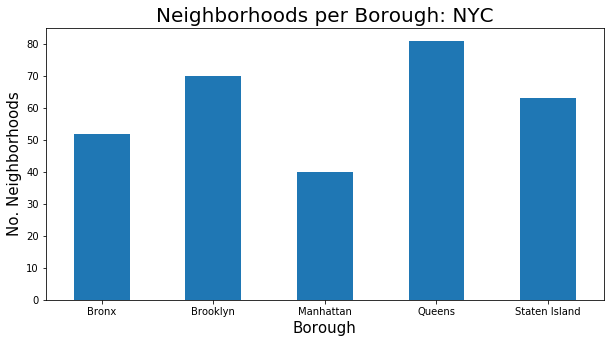

In [10]:
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5))
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [15]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    print(row)
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
chinese_rest_ny.to_csv('chinese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
chinese_rest_ny = pd.read_csv('chinese_rest_ny_tocsv1.csv',index_col=0)
chinese_rest_ny.tail()


( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:1
['Bronx', '

,Borough,Neighborhood,ID,Name
175,Staten Island,Prince's Bay,4bb7d282b35776b0b83dc801,Island Taste
176,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
177,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
178,Bronx,Kingsbridge Heights,4c7851e03badb1f7137c4b54,Yu Hua Restaurant
179,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food


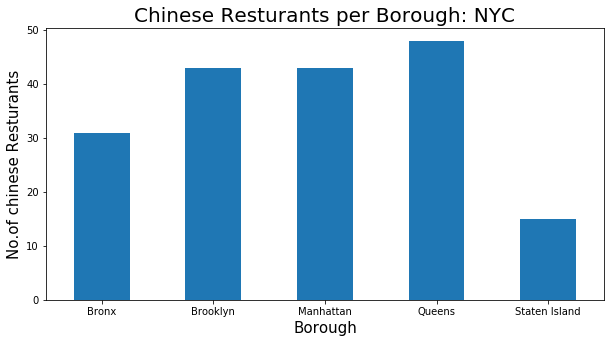

In [16]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5))
plt.title('Chinese Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

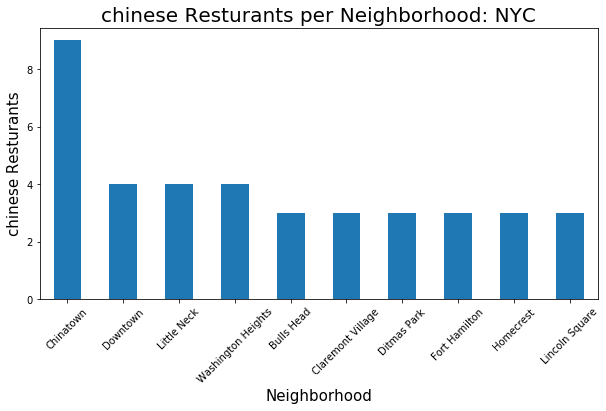

In [17]:
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot.bar(figsize=(10,5))
plt.title('chinese Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('chinese Resturants', fontsize=15)
plt.xticks(rotation = 45)
plt.show()

In [18]:
chinese_rest_ny

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
1,Bronx,Norwood,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen
2,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant
3,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant
4,Bronx,Fordham,4cf30a837e93f04d366a5669,China Wok II
...,...,...,...,...
175,Staten Island,Prince's Bay,4bb7d282b35776b0b83dc801,Island Taste
176,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
177,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
178,Bronx,Kingsbridge Heights,4c7851e03badb1f7137c4b54,Yu Hua Restaurant


In [19]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats_ny.tail()
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny_csv.csv') 

No data available for id= 4c9d5f2654c8a1cd2e71834b
( 1 / 180 ) processed
No data available for id= 4e41d2c4b61ca5ba3b1f9c6b
( 2 / 180 ) processed
( 3 / 180 ) processed
( 4 / 180 ) processed
No data available for id= 4cf30a837e93f04d366a5669
( 5 / 180 ) processed
No data available for id= 4e484885ae60fa72330c9bbc
( 6 / 180 ) processed
No data available for id= 4da0c70b7aee5481bda6b2fe
( 7 / 180 ) processed
No data available for id= 4d2d1728762fa143051f7664
( 8 / 180 ) processed
No data available for id= 4c3a3eb9ae2da59369f303c6
( 9 / 180 ) processed
No data available for id= 4cfece683f846dcb83408d37
( 10 / 180 ) processed
No data available for id= 4cc63e36bde8f04dcbfeb54b
( 11 / 180 ) processed
No data available for id= 4e656e8252b1260c14683b4b
( 12 / 180 ) processed
( 13 / 180 ) processed
No data available for id= 4d7273065f0037048835e0a0
( 14 / 180 ) processed
No data available for id= 4dcdb39352b1f8915b842d57
( 15 / 180 ) processed
( 16 / 180 ) processed
No data available for id= 4b5

In [20]:
chinese_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,0,0,0,0,0
1,Bronx,Norwood,0,0,0,0,0
2,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.2,10
3,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant,5,6,2
4,Bronx,Fordham,0,0,0,0,0
...,...,...,...,...,...,...,...
175,Staten Island,Prince's Bay,0,0,0,0,0
176,Bronx,Allerton,0,0,0,0,0
177,Bronx,Kingsbridge Heights,0,0,0,0,0
178,Bronx,Kingsbridge Heights,0,0,0,0,0


In [21]:
chinese_rest_stats_ny.shape

(180, 7)

In [22]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       180 non-null    object
 1   Neighborhood  180 non-null    object
 2   ID            180 non-null    object
 3   Name          180 non-null    object
 4   Likes         180 non-null    object
 5   Rating        180 non-null    object
 6   Tips          180 non-null    object
dtypes: object(7)
memory usage: 10.0+ KB


In [23]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       180 non-null    object 
 1   Neighborhood  180 non-null    object 
 2   ID            180 non-null    object 
 3   Name          180 non-null    object 
 4   Likes         180 non-null    float64
 5   Rating        180 non-null    object 
 6   Tips          180 non-null    float64
dtypes: float64(2), object(5)
memory usage: 10.0+ KB


In [24]:
chinese_rest_stats_ny.describe()

,Likes,Tips
count,180.000000,180.000000
mean,5.827778,2.277778
std,31.513025,9.654394
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,341.000000,77.000000


In [25]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  North Side
ID              58df00318cfe546addb99246
Name                  Birds of a Feather
Likes                                341
Rating                               8.9
Tips                                  71
Name: 47, dtype: object

In [26]:
chinese_rest_stats_ny['Rating'] = chinese_rest_stats_ny['Rating'].astype(float)
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood             Windsor Terrace
ID              54e39b14498e9c646b42958e
Name                East Wind Snack Shop
Likes                                138
Rating                               8.9
Tips                                  50
Name: 29, dtype: object

In [27]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                Clinton Hill
ID              4a71ff01f964a52016da1fe3
Name                             Kum Kau
Likes                                110
Rating                               7.7
Tips                                  77
Name: 40, dtype: object

In [28]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
75,North Side,8.900
98,South Side,8.100
8,Boerum Hill,8.000
20,Clinton Hill,7.700
28,Downtown,7.625
112,Windsor Terrace,7.450
2,Bay Ridge,7.200
79,Park Slope,7.200
83,Pelham Parkway,7.200
41,Gowanus,6.600


In [29]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Average Rating
1,Brooklyn,3.034884
0,Bronx,1.080645
2,Manhattan,0.000000
3,Queens,0.000000
4,Staten Island,0.000000


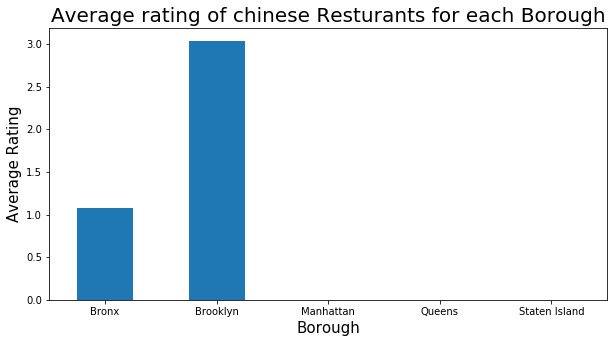

In [30]:
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5))
plt.title('Average rating of chinese Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()


#### Final stats

In [31]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
8,Boerum Hill,8.0
75,North Side,8.9
98,South Side,8.1


In [32]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats


,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,8.0
1,Brooklyn,North Side,40.714823,-73.958809,8.9
2,Brooklyn,South Side,40.710861,-73.958001,8.1


#### Mapping results

In [34]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')


In [35]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')
